In [ ]:
# !pip install datasets
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import tensorflow as tf
from keras import layers, models
from keras.utils import to_categorical
import traceback

In [ ]:
import os
import glob

def clear_temp_files():
    temp_files = glob.glob('temp_file_*.csv')
    for file_path in temp_files:
        try:
            os.remove(file_path)
            print(f"Removed {file_path}")
        except Exception as e:
            print(f"Error occurred while deleting file {file_path}: {e}")

clear_temp_files()


Removed temp_file_4866891e-85ea-458a-803d-4ea3afbdf837.csv
Removed temp_file_8e615ee3-3631-47e8-9a0a-524d4f52a85a.csv
Removed temp_file_6c3cf289-814e-4ca4-85de-b1e8094ef721.csv
Removed temp_file_5465b0f0-e3b7-43ac-9eb9-2472fc5c7bc5.csv
Removed temp_file_1b7e0221-406f-4a4f-9df8-155daa152579.csv
Removed temp_file_e2b28545-7818-4eb0-93d9-ae91ca56cb8b.csv


In [ ]:
import requests
import uuid

def get_download_url(file_path_or_url):
    if 'drive.google.com' in file_path_or_url:
        file_id = file_path_or_url.split('/')[-2]
        download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
        print(f"Downloading from {download_url}")
        session = requests.Session()
        response = session.get(download_url, stream=True)

        # Check for 'download_warning' cookie
        token = None
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                token = value
                break

        # If there's a confirmation token, make another request including it
        if token:
            params = {'id': file_id, 'confirm': token}
            response = session.get(download_url, params=params, stream=True)

        # Check the response's headers to confirm file download
        if 'content-disposition' in response.headers:
            unique_file_name = f'temp_file_{uuid.uuid4()}.csv'
            with open(unique_file_name, 'wb') as f:
                for chunk in response.iter_content(32768):
                    if chunk:  # filter out keep-alive new chunks
                        f.write(chunk)
            file_path_or_url = unique_file_name
        else:
            print("Failed to download the file from Google Drive.")
            return None
    return file_path_or_url


In [ ]:
import numpy as np

def calculate_homophily(adjacency_matrix, Y):
    print(Y.shape)

    same_attribute_count = 0
    total_edge_count = np.sum(adjacency_matrix)

    for i, j in np.argwhere(adjacency_matrix == 1):
        if str(Y[i])== str(Y[j]):
            same_attribute_count += 1

    homophily = same_attribute_count / total_edge_count
    return round(homophily * 100, 2)


In [ ]:
def handle_datasets1(file_path_or_url,dataset):
  df = pd.read_csv(file_path_or_url, sep='\t', header=None, low_memory=False, encoding='unicode_escape')
  df = df.sample(frac=1).reset_index(drop=True)
  identifiers=df.iloc[:,0]
  graph = nx.Graph()
  for node in identifiers:
      graph.add_node(str(node).strip())
  X = df.iloc[:, 1:-1]
  X = np.nan_to_num(X, nan=0)
  Y = df.iloc[:, -1]
  adjacency_matrix=add_edges(dataset, datasets[dataset]['edges'],graph)
  return X,Y,graph,identifiers,adjacency_matrix

In [ ]:

def handle_datasets2(file_path_or_url,dataset):
  df = pd.read_csv(file_path_or_url, low_memory=False)
  # df = df.head(3143)
  df = df.dropna()
  print(df.columns)
  df = df.sample(frac=1).reset_index(drop=True)
  df['MedianIncome'] = df.apply(string_to_float, axis=1)
  identifiers=df.iloc[:,0]
  graph = nx.Graph()
  for node in identifiers:
      graph.add_node(str(node).strip())
  X = df.iloc[:, 4:]
  X = np.nan_to_num(X, nan=0)
  df['label'] = df.apply(compare_and_assign, axis=1)
  Y = df.loc[:, 'label']
  print('NA values: ', df['label'].isna().sum())
  adjacency_matrix=add_edges(dataset, datasets[dataset]['edges'],graph)
  return X,Y,graph,identifiers,adjacency_matrix

def compare_and_assign(row):
    if pd.notna(row['DEM']) and pd.notna(row['GOP']):
        if row['DEM'] > row['GOP']:
            return 'DEM'
        elif row['GOP'] > row['DEM']:
            return 'GOP'
    return pd.NA
def string_to_float(row):
  return float(''.join(row['MedianIncome'].split(',')))


In [ ]:
import sys
import numpy as np
import scipy.sparse as sp
import networkx as nx
import pickle as pkl

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

import numpy as np
import scipy.sparse as sp
import networkx as nx
import pickle as pkl
import random

def handle_datasets3(dataset):
    names = ['tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for name in names:
        file_path_or_url = datasets[dataset][name]
        file_path = get_download_url(file_path_or_url)

        with open(file_path, 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    tx, ty, allx, ally, graph = tuple(objects)
    features = sp.vstack((allx, tx)).tolil()
    labels = np.vstack((ally, ty))
    graph = nx.from_dict_of_lists(graph)

    # Shuffling
    nodes = list(graph.nodes())
    indices = list(range(len(nodes)))
    random.shuffle(indices)

    features = features[indices, :]
    labels = labels[indices, :]

    shuffled_graph = nx.relabel_nodes(graph, {old: nodes[new] for new, old in enumerate(indices)})
    adj = nx.adjacency_matrix(shuffled_graph)

    return features, pd.DataFrame(labels).idxmax(axis=1), shuffled_graph, list(shuffled_graph.nodes()), adj



In [ ]:
import pandas as pd
import networkx as nx


def load_dataset(dataset):
  try:
        if dataset=='pubmed':
          file_path_or_url=dataset
        else:
          file_path_or_url = get_download_url(datasets[dataset]['features'])
          print("File path: ", datasets[dataset]['features'])
          if file_path_or_url is None:
              raise FileNotFoundError(f"Failed to download the dataset: {dataset}")
        if dataset == 'cora' or dataset == 'citeseer':
          X,Y,graph,identifiers,adjacency_matrix=handle_datasets1(file_path_or_url,dataset)
        elif dataset == 'us-county':
          X,Y,graph,identifiers,adjacency_matrix=handle_datasets2(file_path_or_url,dataset)
        elif dataset == 'pubmed':
          X,Y,graph,identifiers,adjacency_matrix=handle_datasets3(dataset)

        homophily=calculate_homophily(adjacency_matrix,Y)
        print("Number of nodes (X rows): ", X.shape[0])
        print("Number of features (X columns): ", X.shape[1])
        print("Number of classes or outputs (Y columns): ", Y.nunique())
        print("Number of edges in graph: ", graph.number_of_edges())
        print(f"Number of nodes in graph {graph.number_of_nodes()}")
        print(f"Homophily of graph {homophily}%")
        return X, Y, identifiers, graph, adjacency_matrix
  except FileNotFoundError:
      print(f"The file {dataset} was not found.")
  except Exception as e:
      # print(f"An error occurred: {e}")
      traceback.print_exc()

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx



def add_edges(dataset, edges_file_path,G):
    print("Loading adjacency_matrix")
    file_path_or_url = get_download_url(edges_file_path)
    if file_path_or_url is None:
        raise FileNotFoundError(f"Failed to download the dataset: {edges_file_path}")

    erroneous_nodes=set()
    def check_node(name, G):
      if not G.has_node(name):
        erroneous_nodes.add(name)
        return False
      return True


    with open(file_path_or_url, 'r') as file:
        for idx, line in enumerate(file):
          if dataset == 'cora' or dataset == 'citeseer':
            nodes = line.strip().split()
          elif dataset == 'us-county':
            if idx: nodes = line.strip().split(',')
            else: continue
          if len(nodes) == 2:
              node1=str(nodes[0])
              node2=str(nodes[1])

              if(check_node(node1,G) and check_node(node2,G)):
                G.add_edge(node1, node2)
              # else:
              #   print(nodes[0],nodes[1],check_node(nodes[0],G),check_node(nodes[1],G))

    print(len(erroneous_nodes)," erroneous nodes found..")
    adjacency_matrix = nx.adjacency_matrix(G)

    return adjacency_matrix



In [ ]:
from sklearn.manifold import SpectralEmbedding
from sklearn.preprocessing import StandardScaler

def spectral_embedding(X, A):
    n_components=5
    # Calculate the normalized Laplacian matrix
    D = np.diag(np.sum(A, axis=1))
    L = D - A

    # Calculate the spectral embedding
    se = SpectralEmbedding(n_components=n_components, random_state=42, affinity='nearest_neighbors')
    embedding = se.fit_transform(X)

    # Standardize the spectral embedding features
    scaler = StandardScaler()
    embedding = scaler.fit_transform(embedding)

    return embedding

def train_linear_se_model(X_train, y_train, A):
    # Perform spectral embedding on the graph and concatenate with original features
    embedding = spectral_embedding(X_train, A)
    X_train_se = np.concatenate((X_train, embedding), axis=1)
    X_train_se= normalize_features(X_train_se)

    # Train a linear model (Logistic Regression) on the enhanced features
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train_se, y_train)

    return model

def train_mlp_se_model(X_train, y_train, A, validation_fraction):
    # Perform spectral embedding on the graph and concatenate with original features
    embedding = spectral_embedding(X_train, A)
    X_train_se = np.concatenate((X_train, embedding), axis=1)
    X_train_se= normalize_features(X_train_se)

    # Train an MLP model with hyperparameter tuning and early stopping on the enhanced features
    parameters = {'hidden_layer_sizes': [(50,), (100,)],
                  'alpha': [0.001, 0.01],
                  'learning_rate_init': [0.001, 0.01]}

    mlp = MLPClassifier(max_iter=500, early_stopping=True, validation_fraction=validation_fraction)
    grid_search = GridSearchCV(mlp, parameters, cv=2, scoring='neg_log_loss', n_jobs=-1)
    grid_search.fit(X_train_se, y_train)

    # Select the best model from the grid search
    best_model = grid_search.best_estimator_

    return best_model


In [ ]:
def train_linear_model(X_train, y_train):
    # Train a linear model (Logistic Regression)
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    return model

# def train_mlp_model(X_train, y_train, X_val, y_val):
#     # Train an MLP model with simplified hyperparameter tuning using GridSearchCV
#     print("Starting MLP model training...")
#     parameters = {'hidden_layer_sizes': [(50,), (100,)],
#                   'alpha': [0.001, 0.01],
#                   'learning_rate_init': [0.001, 0.01]}

#     mlp = MLPClassifier(max_iter=500)
#     grid_search = GridSearchCV(mlp, parameters, cv=2, scoring='neg_log_loss', n_jobs=-1)

#     print("Performing grid search...")
#     grid_search.fit(X_train, y_train)

#     print("Grid search complete.")
#     print("Best Parameters:", grid_search.best_params_)

#     # Select the best model from the grid search
#     best_model = grid_search.best_estimator_

#     print("Best model selected.")
#     return best_model

def train_mlp_model(X_train, y_train, validation_fraction):
    # Train an MLP model with hyperparameter tuning and early stopping
    parameters = {'hidden_layer_sizes': [(50,), (100,)],
                  'alpha': [0.001, 0.01],
                  'learning_rate_init': [0.001, 0.01]}

    mlp = MLPClassifier(max_iter=500, early_stopping=True, validation_fraction=0.1)
    # Note: validation_fraction specifies the proportion of training data to set aside as validation set for early stopping

    grid_search = GridSearchCV(mlp, parameters, cv=2, scoring='neg_log_loss', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    # Select the best model from the grid search
    best_model = grid_search.best_estimator_

    return best_model

def train_base_predictor(X_train, y_train, X, model_type='linear', adj=np.zeros((1,1)), validation_fraction=0.1):
    if model_type == 'linear':
        base_model = train_linear_model(X_train, y_train)
    elif model_type == 'mlp':
        base_model = train_mlp_model(X_train, y_train, validation_fraction)
    elif model_type == 'linear_se':
        base_model = train_linear_se_model(X_train, y_train, adj)
    elif model_type == 'mlp_se':
        base_model = train_mlp_se_model(X_train, y_train, adj, validation_fraction)
    else:
        raise ValueError("Invalid model_type. Choose 'linear' or 'mlp'.")
    if model_type=='linear' or model_type=='mlp':
      return base_model.predict_proba(X)
    else:
      X_expand = np.concatenate((X, spectral_embedding(X, adj)), axis=1)
      X_expand= normalize_features(X_expand)
      return base_model.predict_proba(X_expand)

In [ ]:
# ERROR PROPAGATION

def calculate_normalized_adjacency_matrix(A):

    D_sqrt_inv = np.diag(1 / np.sqrt(np.sum(A, axis=0)))

    Tmp = D_sqrt_inv @ A
    S = Tmp @ D_sqrt_inv

    return S

def calculate_residuals(Y, Z):
    E = Y - Z
    return E

def label_spreading(E, S, alpha,max_iter=50):

    W = np.copy(E)
    for _ in range(max_iter):
        W_new = (1 - alpha) * W + alpha * np.dot(S, W)
        diff = np.linalg.norm(W - W_new)
        if diff < 0.0001:
          break
        W = W_new

    return W

def correct_predictions(Z, E_hat):
    Z_corrected = Z + E_hat
    return Z_corrected

def error_propagation(Z, Y, A,train_end,validaton_end, alpha_values=[0.001,0.01,0.02,0.05, 0.1],max_iter=100):
    S = calculate_normalized_adjacency_matrix(A)
    E = calculate_residuals(Y, Z)
    E[train_end:,:] = 0
    # Best alpha initialization
    best_alpha = None
    max_acc = 0
    outputvalues=None

    # Iterate over possible alpha values to find the best one
    for alpha in alpha_values:
        F = np.copy(E)
        F_hat = label_spreading(F, S, alpha, max_iter)
        Z_corrected = correct_predictions(np.copy(Z), F_hat)

        # Compute error on validation set
        validation_acc = accuracy_score(np.argmax(Y[train_end:validation_end], axis=1), np.argmax(Z_corrected[train_end:validation_end], axis=1))
        print(f"alpha {alpha},validation_acc {validation_acc}")

        # Update best alpha if needed
        if validation_acc > max_acc:
            max_acc = validation_acc
            best_alpha = alpha
            outputvalues=(Z_corrected,F_hat,F)

    print("Best alpha:",best_alpha)
    return outputvalues


In [ ]:
# SCALING

def autoscale(E_hat, E,L):
    E_auto=np.copy(E_hat)
    if E_hat.ndim == 1:
        E_auto = E_auto.reshape(-1, 1)

    sigma = np.mean(np.linalg.norm(E[:L], ord=1, axis=1))
    sigma = max(sigma, 1e-10)  # Avoid division by zero

    norm_E_hat = np.linalg.norm(E_auto[L:], ord=1, axis=1, keepdims=True)
    norm_E_hat = np.maximum(norm_E_hat, 1e-10)  # Avoid division by zero

    E_auto[L:] *= (sigma / norm_E_hat)

    return E_auto


def scaled_fixed_diffusion(E, A, train_end,max_iter=100, error_margin=1e-6):
    # Scaled Fixed Diffusion to adjust the scale of the residual
    D = np.diag(np.sum(A, axis=0))
    D_inv = np.linalg.inv(D)
    E_fixed = np.copy(E)

    for _ in range(max_iter):
        E_fixed[:train_end] = E[:train_end]
        tmp = A @ E_fixed
        res = D_inv @ tmp
        E_fixed[train_end:] = res[train_end:]

    return E_fixed

def apply_scaling_methods(Z_corrected, E_hat, E,scaling_type, A,train_end):
    # Apply scaling methods and correct the predictions
    if scaling_type=='autoscale':
      scaled_autoscale = autoscale(E_hat, E,train_end)
      return Z_corrected + scaled_autoscale
    elif scaling_type=='fixed_diffusion':
      scaled_fixed_diff = scaled_fixed_diffusion(E_hat, A,train_end)
      return Z_corrected + scaled_fixed_diff

In [ ]:
# SMOOTHING FINAL PREDICTIONS

def final_label_propagation(Z_corrected, Y, A,train_end,validation_end,alpha_values=[0.001,0.01,0.02,0.05, 0.1], max_iter=100):

    def propagate_labels(H, S, alpha, max_iter):
        for _ in range(max_iter):
            H_new = (1 - alpha) * H + alpha * np.dot(S, H)
            diff = np.linalg.norm(H - H_new)
            if diff < 0.0001:
                break
            H = H_new
        return H

    # Calculate the normalized adjacency matrix
    S = calculate_normalized_adjacency_matrix(A)

    # Best alpha initialization
    best_alpha = None
    max_acc = 0
    best_H=None

    # Iterate over possible alpha values to find the best one
    for alpha in alpha_values:
        H = np.copy(Z_corrected)
        H = propagate_labels(H, S, alpha, max_iter)
        H[:train_end] = Y[:train_end]  # Keep training labels intact

        # Compute error on validation set
        validation_acc = accuracy_score(np.argmax(Y[train_end:validation_end], axis=1),np.argmax(H[train_end:validation_end], axis=1))
        print(f"alpha {alpha},validation_acc {validation_acc}")
        # Update best alpha if needed
        if validation_acc > max_acc:
            max_acc = validation_acc
            best_alpha = alpha
            best_H=H

    H = best_H
    H[:train_end] = Y[:train_end]  # Keep training labels intact


    print("Best alpha in label propagation: ",best_alpha)
    return H



In [ ]:
def evaluate_accuracies(Y, Z, name, train_end):
    acc = accuracy_score(Y[train_end:], np.argmax(Z[train_end:], axis=1))
    return round(acc * 100, 2)


In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize_features(X):
  min_max_scaler = MinMaxScaler()
  X_normalized = min_max_scaler.fit_transform(X)
  return X_normalized



--- Training on citeseer dataset ---
Loading dataset...
File path:  https://drive.google.com/file/d/1Jxb4mR8sT92Rc2tjBZf2jTo9X9g19iNh/view?usp=drive_link
Loading adjacency_matrix
15  erroneous nodes found..
(3312,)
Number of nodes (X rows):  3312
Number of features (X columns):  3703
Number of classes or outputs (Y columns):  6
Number of edges in graph:  4660
Number of nodes in graph 3312
Homophily of graph 74.12%
Preprocessing labels...
(3312,)


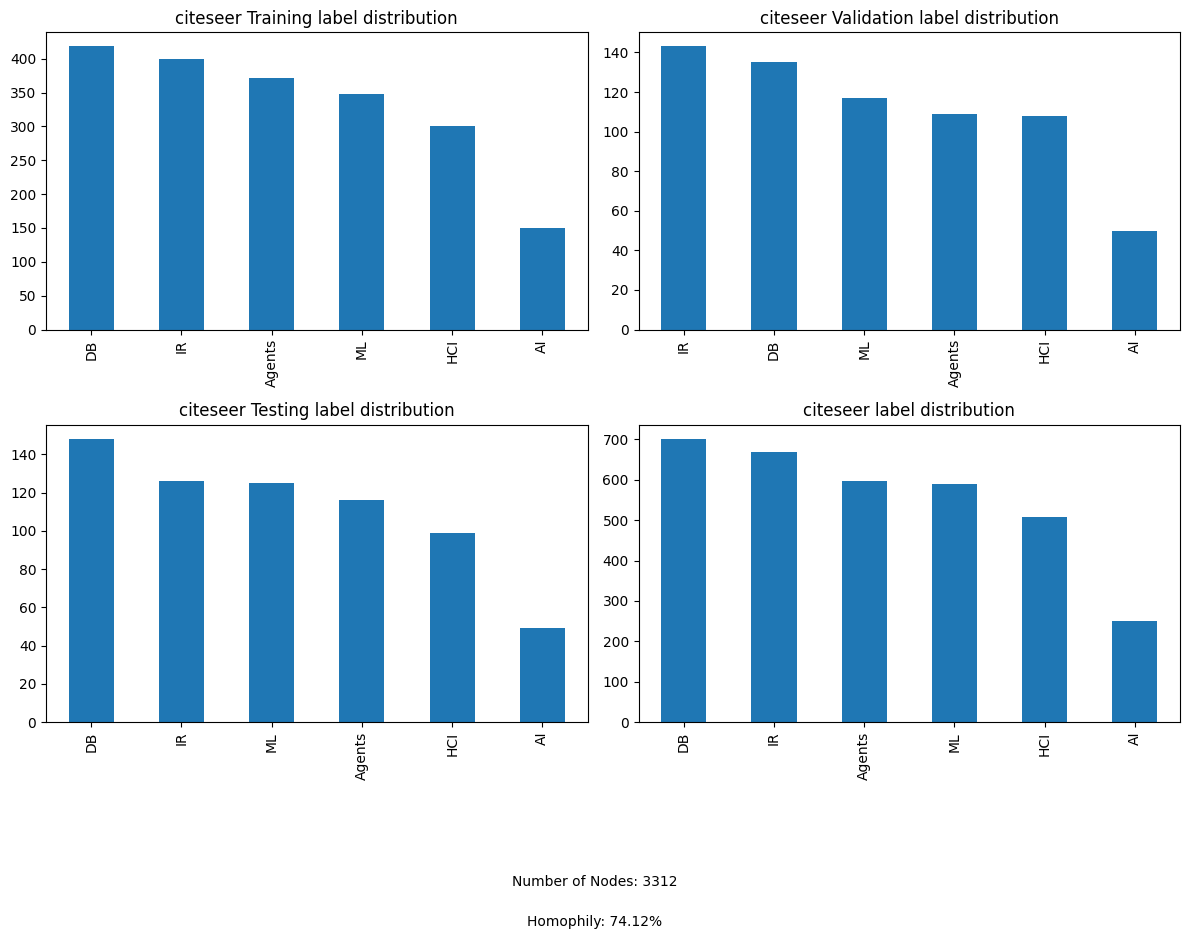

Training LINEAR base predictor...
Time taken for LINEAR base predictor training: 17.517688035964966 seconds
Performing error propagation for linear...
alpha 0.001,validation_acc 0.7054380664652568
alpha 0.01,validation_acc 0.702416918429003
alpha 0.02,validation_acc 0.702416918429003
alpha 0.05,validation_acc 0.7054380664652568
alpha 0.1,validation_acc 0.7054380664652568
Best alpha: 0.001
Time taken for error propagation for linear: 64.25058102607727 seconds
Applying scaling method : linear autoscale...
Time taken for scaling method for linear autoscale : 0.0004818439483642578 seconds
Performing final label propagation smoothing for linear autoscale...
alpha 0.001,validation_acc 0.7311178247734139
alpha 0.01,validation_acc 0.7719033232628398
alpha 0.02,validation_acc 0.7719033232628398
alpha 0.05,validation_acc 0.7643504531722054
alpha 0.1,validation_acc 0.7462235649546828
Best alpha in label propagation:  0.01
Time taken for final label propagation smoothing for linear autoscale 26.17

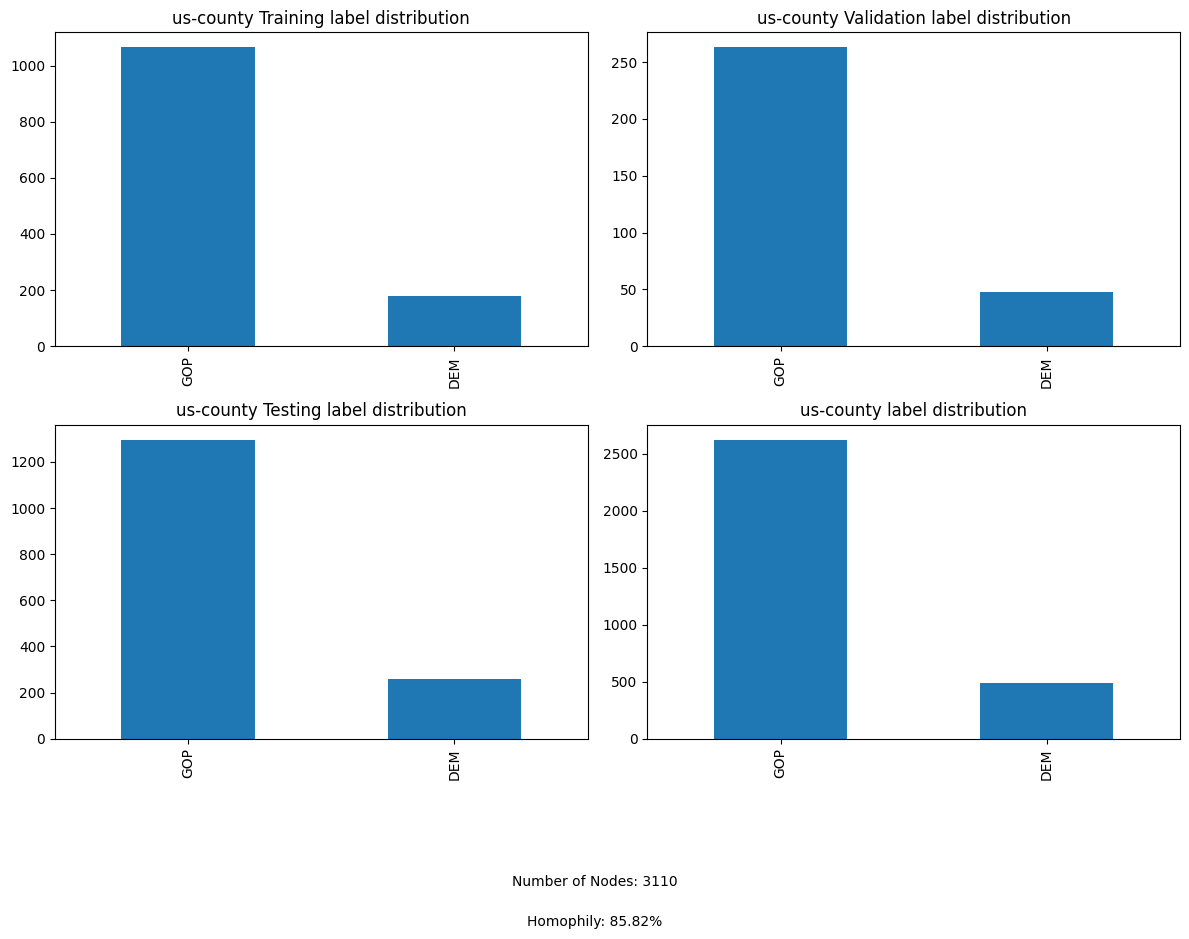

Training LINEAR base predictor...
Time taken for LINEAR base predictor training: 0.014575719833374023 seconds
Performing error propagation for linear...
alpha 0.001,validation_acc 0.8778135048231511
alpha 0.01,validation_acc 0.8810289389067524
alpha 0.02,validation_acc 0.8906752411575563
alpha 0.05,validation_acc 0.8906752411575563
alpha 0.1,validation_acc 0.8842443729903537
Best alpha: 0.02
Time taken for error propagation for linear: 14.000950574874878 seconds
Applying scaling method : linear autoscale...
Time taken for scaling method for linear autoscale : 0.0003018379211425781 seconds
Performing final label propagation smoothing for linear autoscale...
alpha 0.001,validation_acc 0.887459807073955
alpha 0.01,validation_acc 0.8842443729903537
alpha 0.02,validation_acc 0.8906752411575563
alpha 0.05,validation_acc 0.887459807073955
alpha 0.1,validation_acc 0.8713826366559485
Best alpha in label propagation:  0.02
Time taken for final label propagation smoothing for linear autoscale 13.

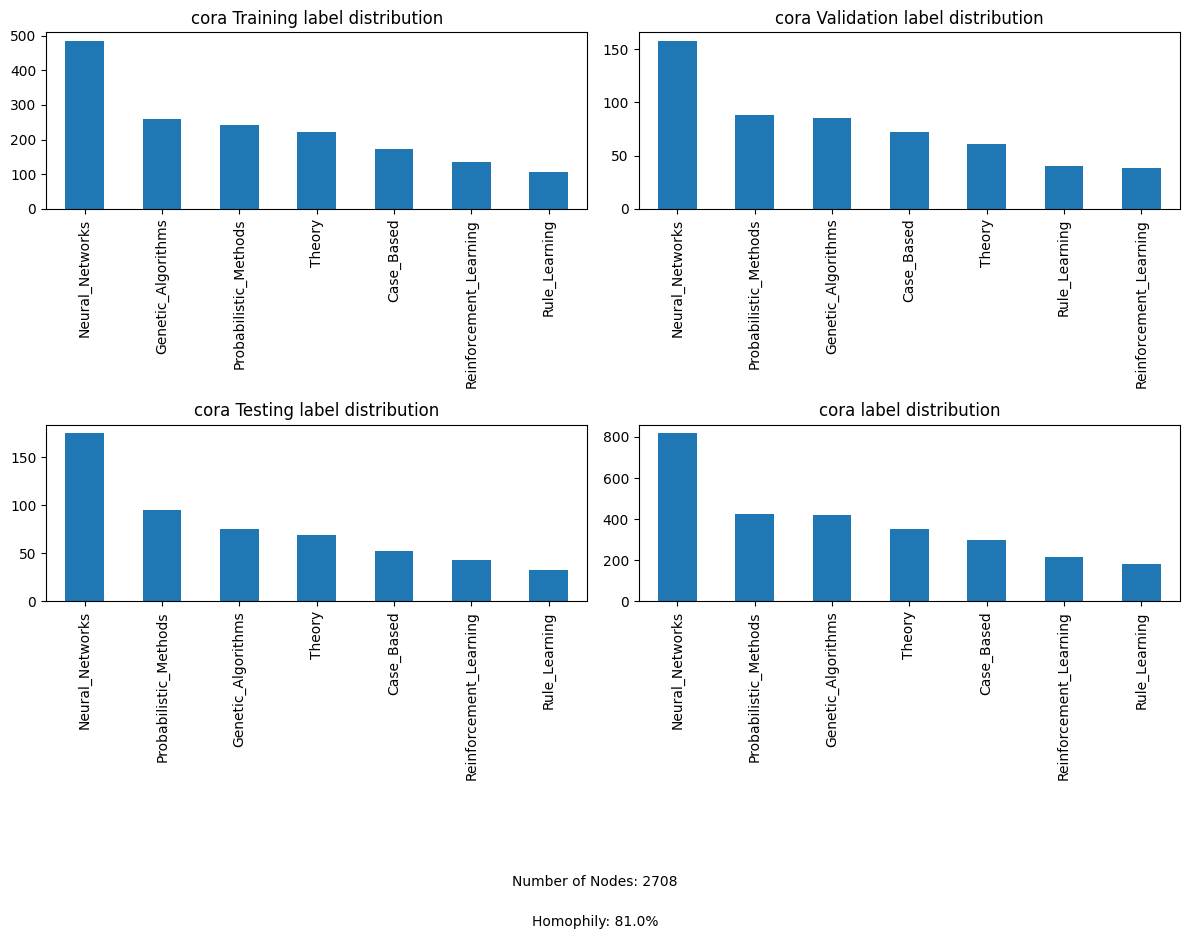

Training LINEAR base predictor...
Time taken for LINEAR base predictor training: 2.269976854324341 seconds
Performing error propagation for linear...
alpha 0.001,validation_acc 0.7453874538745388
alpha 0.01,validation_acc 0.7490774907749077
alpha 0.02,validation_acc 0.7527675276752768
alpha 0.05,validation_acc 0.7527675276752768
alpha 0.1,validation_acc 0.7509225092250923
Best alpha: 0.02
Time taken for error propagation for linear: 15.392262935638428 seconds
Applying scaling method : linear autoscale...
Time taken for scaling method for linear autoscale : 0.00047779083251953125 seconds
Performing final label propagation smoothing for linear autoscale...
alpha 0.001,validation_acc 0.7915129151291513
alpha 0.01,validation_acc 0.8782287822878229
alpha 0.02,validation_acc 0.8874538745387454
alpha 0.05,validation_acc 0.8763837638376384
alpha 0.1,validation_acc 0.8505535055350554
Best alpha in label propagation:  0.02
Time taken for final label propagation smoothing for linear autoscale 15.

In [36]:
datasets = {
    'citeseer': {
        'features':"https://drive.google.com/file/d/1Jxb4mR8sT92Rc2tjBZf2jTo9X9g19iNh/view?usp=drive_link",
        'edges':"https://drive.google.com/file/d/15VeHRUjnCuGCqkz3fieLAivNl35C9bG-/view?usp=drive_link",
        'train_split': 0.6,
        'test_split': 0.2,
        'validation_split': 0.2
    },
    'us-county': {
        'features':"https://drive.google.com/file/d/1OKa4otThbZWZq2cscmN-4MC0zYaG2hXF/view?usp=drive_link",
        'edges':"https://drive.google.com/file/d/1MRS3XcqAYeV53EFAP-FPhghxkU8uaPSR/view?usp=drive_link",
        'train_split': 0.4,
        'test_split': 0.5,
        'validation_split': 0.1
    },
        'cora': {
        'features':"https://drive.google.com/file/d/1vypw02B3Rq6Knen9JBu0kZ-PPbCEQsbJ/view?usp=drive_link",
        'edges':"https://drive.google.com/file/d/16S7tezMQK6ksqtCxhQwyBkP99i5IdYKE/view?usp=drive_link",
        'train_split': 0.6,
        'test_split': 0.2,
        'validation_split': 0.2
    },
    # 'pubmed': {
    #     'tx':"https://drive.google.com/file/d/1eNbbzB5h0kmqNt1Lk6sTMeX1V3RO52DE/view?usp=drive_link",
    #     'ty':"https://drive.google.com/file/d/1Sfr4TzMrO4iFUGTmoXumNsccVHSsoAua/view?usp=drive_link",
    #     'graph':"https://drive.google.com/file/d/1T-ImSb-X9KgiIvcA-Aj9hYh8AWoh103S/view?usp=drive_link",
    #     'allx':"https://drive.google.com/file/d/1tg2qFpzJrNkkSC3OkaktHs4joshwi2Lq/view?usp=drive_link",
    #     'ally':"https://drive.google.com/file/d/1sX27bffBGa7TKh_Uoc6qHAyex7biHxoP/view?usp=drive_link",

    #     'train_split': 0.6,
    #     'test_split': 0.2,
    #     'validation_split': 0.2
    # }
}


import pandas as pd
import time
import matplotlib.pyplot as plt


# Dictionary to store accuracies
accuracies = {}

for dataset_name, dataset_info in datasets.items():
    print(f"\n\n--- Training on {dataset_name} dataset ---")

    # Load the dataset
    print("Loading dataset...")
    X, Y, identifiers, graph, adjacency_matrix = load_dataset(dataset_name)
    X=normalize_features(X)

    # Preprocessing labels
    print("Preprocessing labels...")
    label_encoder = LabelEncoder()
    Y_numerical = label_encoder.fit_transform(Y)
    Y_onehot = to_categorical(Y_numerical)

    # Calculate the split indices
    train_end=  int(dataset_info['train_split'] * X.shape[0])
    validation_end = int((dataset_info['train_split'] +dataset_info['validation_split']) * X.shape[0])

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    Y[:train_end].value_counts().plot(kind='bar', title=dataset_name + ' Training label distribution', ax=axs[0, 0])
    Y[train_end:validation_end].value_counts().plot(kind='bar', title=dataset_name + ' Validation label distribution', ax=axs[0, 1])
    Y[validation_end:].value_counts().plot(kind='bar', title=dataset_name + ' Testing label distribution', ax=axs[1, 0])
    Y.value_counts().plot(kind='bar', title=dataset_name + ' label distribution', ax=axs[1, 1])

    fig.text(0.5, -0.1, f'Number of Nodes: {X.shape[0]}', ha='center', va='top')
    fig.text(0.5, -0.15, f'Homophily: {calculate_homophily(adjacency_matrix, Y)}%', ha='center', va='top')

    plt.tight_layout()
    plt.show()

    for model_type in ['linear', 'mlp', 'linear_se', 'mlp_se']:
        accuracies[(dataset_name, model_type)] = {}

        # Split the datasets
        X_train = X[:train_end]
        Y_train = Y_numerical[:train_end]

        X_test = X[validation_end:]
        Y_test_onehot = Y_onehot[validation_end:]


        # Train base predictor and evaluate
        print(f"Training {model_type.upper()} base predictor...")
        start_time = time.time()
        Z = train_base_predictor(X_train, Y_train, X, model_type, adj=adjacency_matrix if ('se' in model_type) else None, validation_fraction=dataset_info['validation_split'] / dataset_info['train_split'] if (model_type == 'mlp' or model_type == 'mlp_se') else None)
        end_time = time.time()
        print(f"Time taken for {model_type.upper()} base predictor training: {end_time - start_time} seconds")
        accuracies[(dataset_name, model_type)]['base'] = evaluate_accuracies(Y_numerical, Z, f"{model_type.upper()} base", validation_end)

        # Error propagation
        print(f"Performing error propagation for {model_type}...")
        start_time = time.time()
        Z_corrected, E_hat, E = error_propagation(Z, Y_onehot, adjacency_matrix, train_end,validation_end)
        end_time = time.time()
        print(f"Time taken for error propagation for {model_type}: {end_time - start_time} seconds")
        accuracies[(dataset_name, model_type)]['error_propagation'] = evaluate_accuracies(Y_numerical, Z_corrected, f"{model_type} error propagation", validation_end)

        # Scaling
        scaling_methods=['autoscale','fixed_diffusion']
        for scaling_method in scaling_methods:
          name=model_type+" "+ scaling_method
          print(f"Applying scaling method : {name}...")
          start_time = time.time()
          Z_scaled = apply_scaling_methods(Z_corrected, E_hat, E,scaling_method, adjacency_matrix, train_end)
          end_time = time.time()
          print(f"Time taken for scaling method for {name} : {end_time - start_time} seconds")
          accuracies[(dataset_name, model_type)][scaling_method] = evaluate_accuracies(Y_numerical, Z_scaled, name, validation_end)

          # Smoothing of final predictions
          print(f"Performing final label propagation smoothing for {name}...")
          start_time = time.time()
          Ypred = final_label_propagation(Z_scaled, Y_onehot, adjacency_matrix, train_end,validation_end,max_iter= 100)
          end_time = time.time()
          print(f"Time taken for final label propagation smoothing for {name} {end_time - start_time} seconds")
          accuracies[(dataset_name, model_type)]["Label Propagation "+scaling_method] = evaluate_accuracies(Y_numerical, Ypred, "Label Propagation "+name, validation_end)


In [37]:
import pandas as pd
import numpy as np

def highlight_max_in_rows(df, color='lightgreen'):
    attr = f'background-color: {color}; color: black'
    result = pd.DataFrame('', index=df.index, columns=df.columns)
    row_indices = [3, 5] if len(df) >= 6 else df.index[-2:]
    for i in range(0, len(df.columns), 4):
        group_columns = df.columns[i:i+4]
        max_value = df[group_columns].iloc[row_indices].max().max()
        for row_idx in row_indices:
            row = df.index[row_idx]
            result.loc[row, group_columns] = [attr if df.at[row, col] == max_value else '' for col in group_columns]
    return result


def display_accuracies(accuracies):
    df = pd.DataFrame(accuracies)
    styled_df = df.style.apply(lambda x: ['color: black'] * len(x), axis=1)\
                         .apply(lambda x: ['background-color: white'] * len(x), axis=1)\
                         .apply(highlight_max_in_rows, axis=None)

    border_styles = []
    for i in range(5, len(df.columns) + 1, 4):
        border_styles.append({'selector': f'th:nth-child({i}), td:nth-child({i})',
                              'props': [('border-right', '2px solid')]})
    styled_df.set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'black'), ('color', 'white')]},
        {'selector': 'td', 'props': [('font-weight', 'bold')]}
    ] + border_styles, overwrite=False)

    return styled_df

In [38]:
display_accuracies(accuracies)